In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from colorama import Fore

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [3]:
df = pd.read_csv("./data/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

frequency = '1h'

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

df_max = df.resample(frequency, on='datetime').max()
df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-10 14:00:00,2048.0,2.0,1.130758e+09,1.276808,500.0,60398090.0,60414274.0,10.0,14.0
2021-11-10 15:00:00,2048.0,2.0,1.559351e+09,0.996645,460.0,93936583.0,94259814.0,10.0,15.0
2021-11-10 16:00:00,2048.0,2.0,1.494233e+09,0.983066,480.0,95931083.0,96020918.0,10.0,16.0
2021-11-10 17:00:00,2048.0,2.0,1.600532e+09,0.983279,480.0,97132575.0,97360300.0,10.0,17.0
2021-11-10 18:00:00,2048.0,2.0,1.010856e+09,0.999460,440.0,97207925.0,97417298.0,10.0,18.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


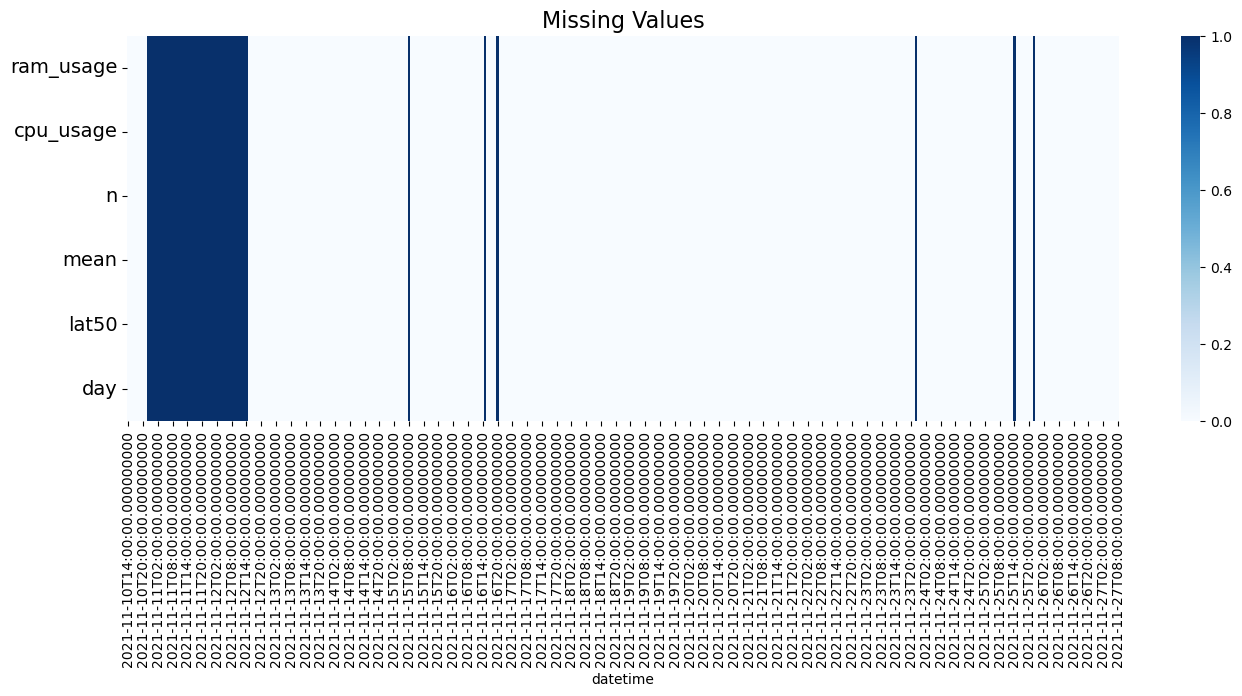

In [4]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Remove the big portion of missing values

In [5]:
# Set the filter condition based on the desired date and time
df_max_reset = df_max.reset_index()
df_max_reset['datetime'] = pd.to_datetime(df_max_reset['datetime'])
filter_condition = df_max_reset['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_max_reset[filter_condition].set_index('datetime')

Plot filtered datafarame

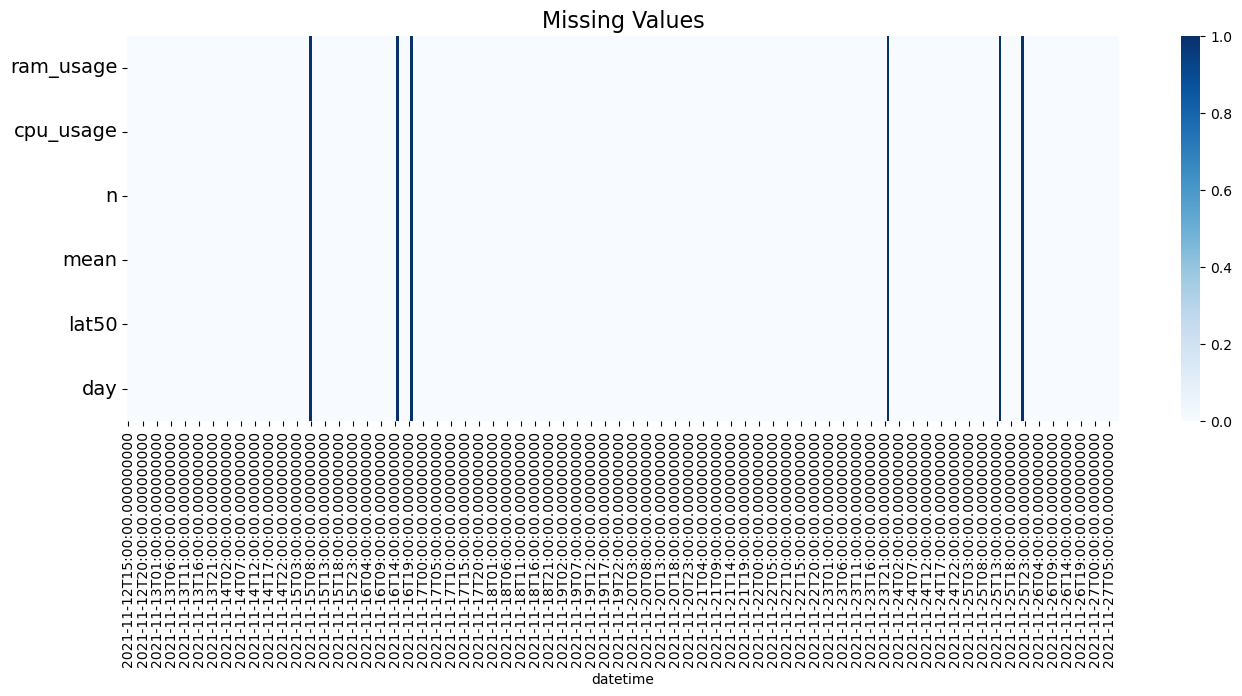

In [6]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(filtered_df.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Interpolate in order to fill the null values in the df

In [7]:
interpolated_df = filtered_df.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

In [8]:
interpolated_df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1.203683e+09,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1.870483e+09,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1.847726e+09,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1.854063e+09,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1.766617e+09,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


# ARIMA 

In [9]:
train_size = int(0.7 * len(interpolated_df))
test_size = len(interpolated_df) - train_size

univariate_cpu_usage_df = interpolated_df.reset_index()[['datetime', 'cpu_usage']].copy()
univariate_cpu_usage_df.columns = ['ds', 'y']

train_cpu_usage = univariate_cpu_usage_df.iloc[:train_size, :]

x_train_cpu_usage, y_train_cpu_usage = pd.DataFrame(univariate_cpu_usage_df.iloc[:train_size, 0]), pd.DataFrame(univariate_cpu_usage_df.iloc[:train_size, 1])
x_valid_cpu_usage, y_valid_cpu_usage = pd.DataFrame(univariate_cpu_usage_df.iloc[train_size:, 0]), pd.DataFrame(univariate_cpu_usage_df.iloc[train_size:, 1])

# univariate_ram_usage_df = df_max[['datetime', 'ram_usage']].copy()
# univariate_ram_usage_df.columns = ['ds', 'y']

print(len(x_train_cpu_usage), len(x_valid_cpu_usage))

247 107


In [12]:
warnings.filterwarnings('ignore')

# Fit model
model = ARIMA(y_train_cpu_usage, order=(5,0,5)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
model_fit = model.fit()

#model_fit.summary()
y_pred_cpu_usage = model_fit.predict()

# reshape for consistency
y_valid_cpu_usage_res = y_valid_cpu_usage.to_numpy().ravel()
valid_len = len(y_valid_cpu_usage_res)
y_pred_cpu_usage_res = y_pred_cpu_usage[:valid_len]

# Calcuate metrics
score_mae_cpu_usage = mean_absolute_error(y_valid_cpu_usage_res, y_pred_cpu_usage_res)
score_rmse_cpu_usage = math.sqrt(mean_squared_error(y_valid_cpu_usage_res, y_pred_cpu_usage_res))
score_mape_cpu_usage = mean_absolute_percentage_error(y_valid_cpu_usage_res, y_pred_cpu_usage_res)

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse_cpu_usage))
print('MAE: {}'.format(score_mae_cpu_usage))
print('MAPE: {}'.format(score_mape_cpu_usage))


RMSE: 0.4643927494166062
MAE: 0.3963849449615718
MAPE: 0.5265880831911844


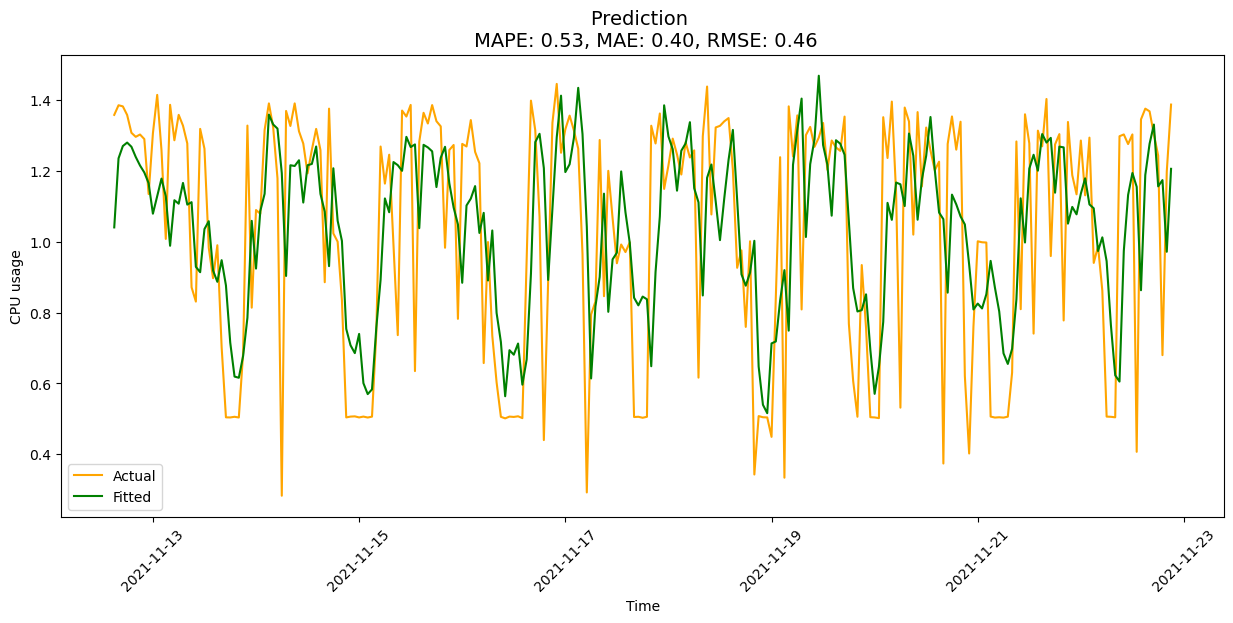

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plt.plot(y_train_cpu_usage.set_index(x_train_cpu_usage['ds']), color='orange')
plt.plot(pd.DataFrame(model_fit.fittedvalues).set_index(x_train_cpu_usage['ds']), color='green')
#plt.title('RSS: %.4f' % sum((model_fit.fittedvalues - y_train_cpu_usage) ** 2))
plt.xticks(rotation=45)
plt.title(f'Prediction \n MAPE: {score_mape_cpu_usage:.2f}, MAE: {score_mae_cpu_usage:.2f}, RMSE: {score_rmse_cpu_usage:.2f}', fontsize=14)
plt.xlabel('Time')
plt.ylabel('CPU usage')
plt.legend(['Actual', 'Fitted'])
plt.show()

Forecast only the validation part for consistence evaluation, retrain the model at each step

In [14]:
n_iterations = test_size 

# ignore convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

In [15]:
# make a copy of training set
y_train_temp = y_train_cpu_usage.copy()

In [16]:
# first prediction
# Fit model
model = ARIMA(y_train_temp, order=(5,0,5)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
model_fit = model.fit()

# predict 1 point
prediction = model_fit.forecast()
prediction = pd.DataFrame(prediction, columns=['y'])

# initialize prediction array
forecasted_cpu_usage = prediction

# update training set
y_train_temp = pd.concat([y_train_temp, y_valid_cpu_usage['y'][:1]], ignore_index=False)


In [17]:
for i in range(1, n_iterations):
    print(f'Iteration {i} \n')
    # Fit model
    model = ARIMA(y_train_temp, order=(5,0,5)) # (p,d,q) --> p = lag order, d = degree of differencing, q = order of moving average
    model_fit = model.fit()

    # predict 1 point
    prediction = model_fit.forecast()
    prediction = pd.DataFrame(prediction, columns=['y'])

    # update prediction array
    forecasted_cpu_usage = pd.concat([forecasted_cpu_usage, prediction])

    # update training set
    y_train_temp = pd.concat([y_train_temp, y_valid_cpu_usage['y'].iloc[[i]]], ignore_index=False)

Iteration 1 

Iteration 2 

Iteration 3 

Iteration 4 

Iteration 5 

Iteration 6 

Iteration 7 

Iteration 8 

Iteration 9 

Iteration 10 

Iteration 11 

Iteration 12 

Iteration 13 

Iteration 14 

Iteration 15 

Iteration 16 

Iteration 17 

Iteration 18 

Iteration 19 

Iteration 20 

Iteration 21 

Iteration 22 

Iteration 23 

Iteration 24 

Iteration 25 

Iteration 26 

Iteration 27 

Iteration 28 

Iteration 29 

Iteration 30 

Iteration 31 

Iteration 32 

Iteration 33 

Iteration 34 

Iteration 35 

Iteration 36 

Iteration 37 

Iteration 38 

Iteration 39 

Iteration 40 

Iteration 41 

Iteration 42 

Iteration 43 

Iteration 44 

Iteration 45 

Iteration 46 

Iteration 47 

Iteration 48 

Iteration 49 

Iteration 50 

Iteration 51 

Iteration 52 

Iteration 53 

Iteration 54 

Iteration 55 

Iteration 56 

Iteration 57 

Iteration 58 

Iteration 59 

Iteration 60 

Iteration 61 

Iteration 62 

Iteration 63 

Iteration 64 

Iteration 65 

Iteration 66 

Iteration 67 

Iter

In [18]:
forecasted_cpu_usage[:10]

,y
247,1.172576
248,1.090585
249,1.024650
250,0.860750
251,1.226583
252,1.272476
253,0.954922
254,0.727864
255,0.836756
256,0.927583


In [19]:
# reshape for consistency
y_valid_cpu_usage_res = y_valid_cpu_usage.to_numpy().ravel()
valid_len = len(y_valid_cpu_usage_res)
#y_pred_cpu_usage_res = y_pred_cpu_usage[:valid_len]

# Calcuate metrics
score_mae_cpu_usage = mean_absolute_error(y_valid_cpu_usage_res, forecasted_cpu_usage)
score_rmse_cpu_usage = math.sqrt(mean_squared_error(y_valid_cpu_usage_res, forecasted_cpu_usage))
score_mape_cpu_usage = mean_absolute_percentage_error(y_valid_cpu_usage_res, forecasted_cpu_usage)

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse_cpu_usage))
print('MAE: {}'.format(score_mae_cpu_usage))
print('MAPE: {}'.format(score_mape_cpu_usage))


RMSE: 0.2944883579361677
MAE: 0.23727446267761387
MAPE: 0.3216618026695315


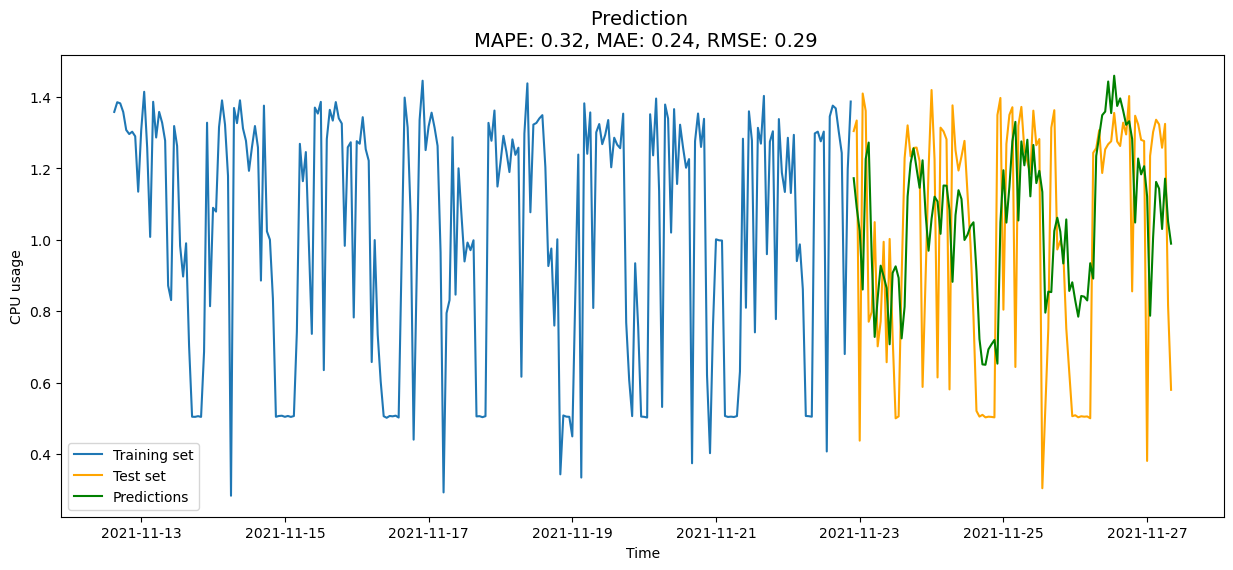

In [20]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

plt.plot(y_train_cpu_usage.set_index(x_train_cpu_usage['ds']))
plt.plot(pd.DataFrame(y_valid_cpu_usage_res).set_index(x_valid_cpu_usage['ds']), color='orange')
plt.plot(pd.DataFrame(forecasted_cpu_usage).set_index(x_valid_cpu_usage['ds']), color='green')
plt.xticks(rotation=45)
plt.title(f'Prediction \n MAPE: {score_mape_cpu_usage:.2f}, MAE: {score_mae_cpu_usage:.2f}, RMSE: {score_rmse_cpu_usage:.2f}', fontsize=14)
plt.xlabel('Time')
plt.ylabel('CPU usage')
plt.legend(['Training set', 'Test set', 'Predictions'])
plt.xticks(rotation=0)
plt.show()